In [19]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from utils.tracking_analysis.tracking_plotting import *
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice, fig4_plotting_colours
from utils.reaction_time_utils import get_bpod_trial_nums_per_session
from utils.post_processing_utils import get_all_experimental_records
from utils.post_processing_utils import remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.plotting import output_significance_stars_from_pval
import statsmodels.api as sm

In [113]:
def rolling_mean_plotting(data, y_var, ipsi_contra='contra_data', win=40):
    data = data[[y_var, 'trial_type']]
    data = data[data['trial_type'] == ipsi_contra].dropna()
  
    x_values = data[y_var].index.values
    y_values = data[y_var].values

    # Convert x_values to a Pandas Series to calculate the rolling mean
    x_series = pd.Series(x_values)
    y_series = pd.Series(y_values)

    # Calculate the rolling mean with a window size of your choice, e.g., 5
    rolling_x = x_series.rolling(window=win).mean()
    rolling_y = y_series.rolling(window=win).mean()

    # Create a scatter plot using the rolling means
    plt.scatter(rolling_x, rolling_y)
    plt.title('Scatter Plot of Rolling Mean')
    plt.xlabel('Rolling Mean of X')
    plt.ylabel('Rolling Mean of Y')
    plt.show()


In [84]:
def perform_single_lag_regression(all_session_data, lag, test_col='turn angle'):
    all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
    all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
    all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])
    all_session_data[f'choice_t_minus{lag}_match'] = (all_session_data[f'choice_t_minus_{lag}'] == all_session_data['choice'])
    all_session_data[f'turn_ang_t_minus_{lag}'] = shift_respecting_index(all_session_data[test_col], lag)

    test_var = f'turn_ang_t_minus_{lag}'


    contra_trials = all_session_data[(all_session_data['trial_type'].notna())
                                     & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                     & (all_session_data[f'choice_t_minus{lag}_match'] == True)
                                     & (all_session_data['First choice correct'] == 1)]
    df = contra_trials[['APE_peaks', test_var]].copy()
    df = df.dropna().reset_index(drop=True)

    df.loc[:, test_var] = df[test_var].astype(float)
    df.loc[:, 'APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

    df.loc[:, 'APE_peaks'] = df['APE_peaks'].astype(float)
    

    y = df[test_var]
    X = df['APE_peaks'].astype(float)
    print(y.shape)
    X = sm.add_constant(X)
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    return model.params[1:], model.pvalues[1:], contra_trials

In [125]:
def shift_respecting_index(vals_to_shift, shift_size):
    """
    Shifts a pandas df column by shift_size indices
    but if there is a discontinuity in the index,
    replaces the shifted index with nan
    """
    
    shifted_vals = vals_to_shift.shift(periods=shift_size)

    # Detect discontinuities in the index
    trial_num_diff = vals_to_shift.index.to_series().diff().fillna(shift_size)

    # Identify where the shift should result in NaN due to discontinuities
    discontinuities = trial_num_diff < shift_size
    shifted_vals[discontinuities] = np.nan

    return shifted_vals


In [24]:
recording_site = 'tail'
all_experiments = get_all_experimental_records()

(477,)


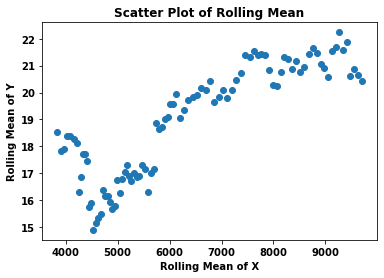

(857,)


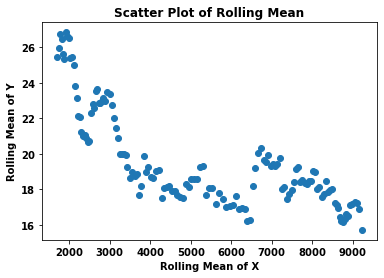

(436,)


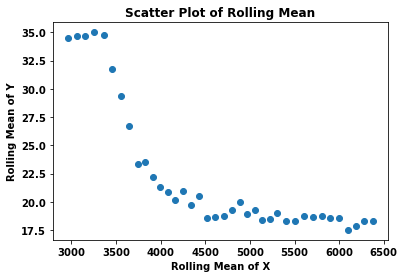

(458,)


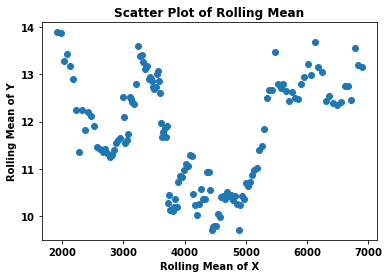

(572,)


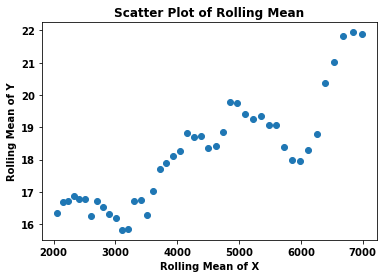

(838,)


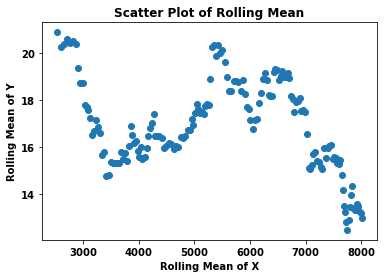

In [132]:
mice = change_over_time_mice[recording_site]
num_lags = 1
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
pvals = np.zeros([num_mice, num_lags])

for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_movement_bias_{}.pkl'.format(mouse))
    with_movement_data = pd.read_pickle(bias_file)
    contra_side = with_movement_data[(with_movement_data['trial_type'] == 'contra_data') & (with_movement_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'}
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
        
    with_movement_data['choice'] = with_movement_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    with_movement_data['choice'] = with_movement_data['choice'].map({'contra': 1, 'ipsi': 0})
    with_movement_data['turn ang abs diff'] = np.abs(with_movement_data['turn angle'].diff())

    for lag in range(1, num_lags + 1):
        coefs[m, lag-1], pvals[m, lag-1], df = perform_single_lag_regression(with_movement_data, -lag, test_col='turn ang abs diff')
    rolling_mean_plotting(df, 'turn_ang_t_minus_-1' , ipsi_contra='ipsi_data', win=50)
    #plt.figure()
    #plt.scatter(df.index.values, df['turn_ang_t_minus_-1'].values)
    

In [127]:
coefs, pvals

(array([[-1.54551918],
        [-0.57103412],
        [-2.75932922],
        [-0.67914111],
        [-0.66186555],
        [ 0.23159339]]),
 array([[0.12279411],
        [0.36429493],
        [0.01239411],
        [0.37704226],
        [0.29442041],
        [0.71332736]]))

In [96]:
def plot_multilag_coefs_accross_mice(recording_site, coefs, axs, color='blue'):
    # Calculate the mean and SEM across axis=0
    mean_coefs = np.mean(coefs, axis=0)
    sem_coefs = stats.sem(coefs, axis=0)

    # Create the x-axis values
    x = (np.arange(mean_coefs.shape[0]) + 1).astype(int)

    # Plot the mean
    axs.plot(x, mean_coefs, label=recording_site, color=color)


    # Plot the shaded error bars using SEM
    axs.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color=color, alpha=0.3, label='')
    plot_sig_stars_multilag(coefs, color, axs)
    # Adding labels and legend
    axs.set_ylabel('Regression coef')
    axs.set_xlabel('Number of trials back')
    #axs.set_ylim([-0.01, 0.01])
    plt.legend(frameon=False)

In [97]:
def plot_sig_stars_multilag(coefs, color, axs):
    second_order_coefs, second_order_pvals = test_for_coef_trend_against_zero_mulit_lag(coefs)
    for lag_num in range(0, len(second_order_coefs)):
        sig_stars = output_significance_stars_from_pval(second_order_pvals[lag_num])
        if sig_stars != 'n.s.':
            if second_order_coefs[lag_num] >= 0:
                y = 0.01
            else:
                y=-0.01
            axs.text(lag_num + 1, y, sig_stars, ha='center', fontsize=12, color=color)
            

In [151]:
def test_for_coef_trend_against_zero_mulit_lag(coefs):
    pvals = []
    slopes = []
    for lag_num in range(0, coefs.shape[1]):
        test = stats.ttest_1samp(coefs.T[lag_num], 0)
        pvals.append(test.pvalue)
        slopes.append(test.statistic)
    print(pvals, slopes)
    return slopes, pvals

[0.021945497520668628] [-3.280372384979199]


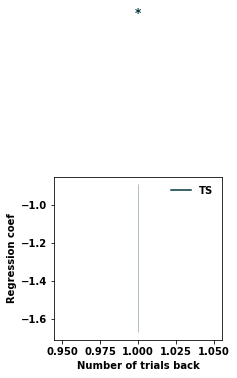

In [152]:
fig, axs = plt.subplots(1,1, figsize=[3,3])
plot_multilag_coefs_accross_mice('TS', coefs, axs, color=fig4_plotting_colours[recording_site][0])

# Frechet distance

In [145]:
# Define the Frechet distance functions as before
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def frechet_distance(P, Q):
    """
    Computes the Frechet distance between two trajectories P and Q.
    P and Q are lists of tuples, where each tuple represents a point (x, y).
    """
    n = len(P)
    m = len(Q)
    
    # Create a table to store intermediate results
    dp = np.ones((n, m)) * -1
    
    def recursive_c(i, j):
        # If this subproblem has already been computed, return its result
        if dp[i, j] != -1:
            return dp[i, j]
        
        # Base case: both points are at the start of their respective trajectories
        if i == 0 and j == 0:
            dp[i, j] = euclidean_distance(P[0], Q[0])
        # Base case: one of the points is at the start of its trajectory
        elif i > 0 and j == 0:
            dp[i, j] = max(recursive_c(i - 1, 0), euclidean_distance(P[i], Q[0]))
        elif i == 0 and j > 0:
            dp[i, j] = max(recursive_c(0, j - 1), euclidean_distance(P[0], Q[j]))
        # Recursive case: compute the distance considering all previous possibilities
        else:
            dp[i, j] = max(min(recursive_c(i - 1, j), recursive_c(i, j - 1), recursive_c(i - 1, j - 1)),
                           euclidean_distance(P[i], Q[j]))
        
        return dp[i, j]
    
    return recursive_c(n - 1, m - 1)

# Function to compute Frechet distance for each row in the dataframe
def compute_frechet_for_row(row):
    # Extract x and y for trajectory 1
    trajectory1_x = row['head x']
    trajectory1_y = row['head y']
    
    # Extract x and y for trajectory 2
    trajectory2_x = row['head x t plus 1']
    trajectory2_y = row['head y t plus 1']
    
    # Combine x and y into (x, y) tuples for each trajectory
    trajectory1 = list(zip(trajectory1_x, trajectory1_y))
    trajectory2 = list(zip(trajectory2_x, trajectory2_y))
    
    # Compute and return the Frechet distance between trajectory1 and trajectory2
    return frechet_distance(trajectory1, trajectory2)



In [148]:
mice = change_over_time_mice[recording_site]
num_lags = 1
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
pvals = np.zeros([num_mice, num_lags])

for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_movement_bias_{}.pkl'.format(mouse))
    with_movement_data = pd.read_pickle(bias_file)
    contra_side = with_movement_data[(with_movement_data['trial_type'] == 'contra_data') & (with_movement_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'}
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    
    with_movement_data['choice'] = with_movement_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    with_movement_data['choice'] = with_movement_data['choice'].map({'contra': 1, 'ipsi': 0})
    lag = -1
    with_movement_data['head x t plus 1'] = shift_respecting_index(with_movement_data['head x'], lag)
    with_movement_data['head y t plus 1'] = shift_respecting_index(with_movement_data['head y'], lag)
    with_movement_data[f'choice_t_minus_{lag}'] = shift_respecting_index(with_movement_data['choice'], lag)
    with_movement_data[f'stim_t_minus_{lag}'] = shift_respecting_index(with_movement_data['Trial type'], lag)
    with_movement_data[f'stim_t_minus{lag}_match'] = (with_movement_data[f'stim_t_minus_{lag}'] == with_movement_data['Trial type'])
    with_movement_data[f'choice_t_minus{lag}_match'] = (with_movement_data[f'choice_t_minus_{lag}'] == with_movement_data['choice'])
    
    contra_trials = with_movement_data[(with_movement_data['trial_type'].notna())
                                     & (with_movement_data[f'stim_t_minus{lag}_match'] == True)
                                     & (with_movement_data[f'choice_t_minus{lag}_match'] == True)
                                     & (with_movement_data['First choice correct'] == 1)]

    df_for_reg = contra_trials[['head x', 'head y', 'head x t plus 1', 'head y t plus 1', 'APE_peaks']].dropna()
    df_for_reg['frechet_distance'] = df_for_reg.apply(compute_frechet_for_row, axis=1)
    test_var = 'frechet_distance'
    df = df_for_reg[['APE_peaks', test_var]].copy()
    df = df.dropna().reset_index(drop=True)

    df.loc[:, test_var] = df[test_var].astype(float)
    df.loc[:, 'APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

    df.loc[:, 'APE_peaks'] = df['APE_peaks'].astype(float)
    

    y = df[test_var]
    X = df['APE_peaks'].astype(float)
    print(y.shape)
    X = sm.add_constant(X)
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    coefs[m, 0], pvals[m, 0] = model.params[1:], model.pvalues[1:]
    

(662,)
(1139,)
(583,)
(708,)
(678,)
(1251,)


In [149]:
coefs, pvals

(array([[-2.0366714 ],
        [-1.1936008 ],
        [-1.90720747],
        [-0.57696474],
        [-2.20218362],
        [ 0.22462534]]),
 array([[0.02211063],
        [0.06656671],
        [0.06985003],
        [0.47834693],
        [0.01346564],
        [0.75780195]]))

[0.021945497520668628]


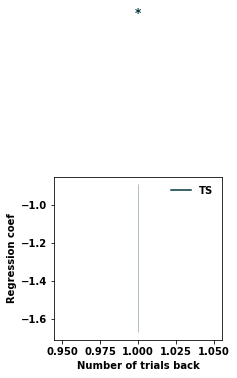

In [150]:
fig, axs = plt.subplots(1,1, figsize=[3,3])
plot_multilag_coefs_accross_mice('TS', coefs, axs, color=fig4_plotting_colours[recording_site][0])